In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler # StandardScaler

from sklearn.metrics import mean_squared_error

import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
g1 = pd.read_csv('data/G(배) 수위#1 (F_CV).csv', header=None)
g1.columns = ['date', 'height1']

g2 = pd.read_csv('data/G(배) 수위#2 (F_CV).csv', header=None)
g2.columns = ['date', 'height2']

In [4]:
merged_df = pd.merge(g1, g2, on='date')
merged_df.head(), merged_df.describe()

(                  date  height1  height2
 0  2018-01-01 00:01:00    3.407    3.416
 1  2018-01-01 00:02:00    3.407    3.416
 2  2018-01-01 00:03:00    3.407    3.416
 3  2018-01-01 00:04:00    3.397    3.417
 4  2018-01-01 00:05:00    3.397    3.416,
           height1     height2
 count 2624769.000 2624769.000
 mean        3.491       3.507
 std         0.328       0.317
 min         0.000       0.000
 25%         3.355       3.366
 50%         3.527       3.543
 75%         3.696       3.712
 max         4.100       4.096)

In [5]:
merged_df['height1'] < 0, merged_df['height2'] < 0

(0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height1, Length: 2624769, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 2624764    False
 2624765    False
 2624766    False
 2624767    False
 2624768    False
 Name: height2, Length: 2624769, dtype: bool)

In [6]:
merged_df.isna().sum()

date       0
height1    0
height2    0
dtype: int64

In [7]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.set_index('date', inplace=True)

In [8]:
merged_df = merged_df.resample('h').mean()
merged_df.head(), merged_df.tail()

(                     height1  height2
 date                                 
 2018-01-01 00:00:00    3.348    3.360
 2018-01-01 01:00:00    3.235    3.246
 2018-01-01 02:00:00    3.262    3.274
 2018-01-01 03:00:00    3.341    3.353
 2018-01-01 04:00:00    3.419    3.431,
                      height1  height2
 date                                 
 2022-12-31 19:00:00    3.351    3.363
 2022-12-31 20:00:00    3.388    3.401
 2022-12-31 21:00:00    3.393    3.407
 2022-12-31 22:00:00    3.359    3.373
 2022-12-31 23:00:00    3.348    3.366)

In [9]:
type(merged_df)

pandas.core.frame.DataFrame

In [10]:
merged_df['height'] = merged_df[['height1', 'height2']].mean(axis=1)
merged_df = merged_df[['height']]
print(merged_df)

                     height
date                       
2018-01-01 00:00:00   3.354
2018-01-01 01:00:00   3.240
2018-01-01 02:00:00   3.268
2018-01-01 03:00:00   3.347
2018-01-01 04:00:00   3.425
...                     ...
2022-12-31 19:00:00   3.357
2022-12-31 20:00:00   3.394
2022-12-31 21:00:00   3.400
2022-12-31 22:00:00   3.366
2022-12-31 23:00:00   3.357

[43824 rows x 1 columns]


In [11]:
merged_df.isna().sum()

height    63
dtype: int64

In [12]:
merged_df.describe()

,height
count,43761.000
mean,3.499
std,0.305
min,0.000
25%,3.358
50%,3.534
75%,3.701
max,4.091


In [13]:
# 선형식 보간법
# merged_df['height'].interpolate(method='linear', inplace=True)

# 다항식 보간법
merged_df['height'] = merged_df['height'].interpolate(method='polynomial', order=2)

In [14]:
start_date = pd.Timestamp('2019-10-18 20:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:00')

# 주어진 기간 내의 데이터를 sample로 설정
sample_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]

sample_df

,height
date,
2019-10-18 20:00:00,3.496
2019-10-18 21:00:00,3.561
2019-10-18 22:00:00,3.631
2019-10-18 23:00:00,3.707
2019-10-19 00:00:00,3.795
...,...
2022-06-30 19:00:00,3.678
2022-06-30 20:00:00,3.726
2022-06-30 21:00:00,3.786


In [15]:
train_start = start_date
train_end = pd.Timestamp('2021-08-31 23:00:00')
val_start = pd.Timestamp('2021-09-01 00:00:00')
val_end = pd.Timestamp('2022-01-31 23:00:00')
test_start = pd.Timestamp('2022-02-01 00:00:00')
test_end = end_date

In [16]:
train_set = sample_df.loc[train_start:train_end]
val_set = sample_df.loc[val_start:val_end]
test_set = sample_df.loc[test_start:test_end]

train_set.shape, val_set.shape, test_set.shape

((16396, 1), (3672, 1), (3600, 1))

In [17]:
label_df = merged_df[merged_df.index > end_date]
label_df

,height
date,
2022-07-01 00:00:00,3.704
2022-07-01 01:00:00,3.596
2022-07-01 02:00:00,3.524
2022-07-01 03:00:00,3.594
2022-07-01 04:00:00,3.656
...,...
2022-12-31 19:00:00,3.357
2022-12-31 20:00:00,3.394
2022-12-31 21:00:00,3.400


In [18]:
# NaN 값 확인
print("NaN values in train_data before scaling:", train_set.isna().sum().sum())
print("NaN values in val_data before scaling:", val_set.isna().sum().sum())
print("NaN values in test_data before scaling:", test_set.isna().sum().sum())

NaN values in train_data before scaling: 0
NaN values in val_data before scaling: 0
NaN values in test_data before scaling: 0


In [19]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train_set)

scaled_val = scaler.transform(val_set)

scaled_test = scaler.transform(test_set)

In [20]:
print(np.isnan(scaled_train).sum())  # NaN 값의 수 출력
print(np.isnan(scaled_val).sum())
print(np.isnan(scaled_test).sum())

0
0
0


In [21]:
def create_sequences(df, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df[i:i+seq_length]
        y = target_data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X_train, y_train = create_sequences(scaled_train, scaled_train, seq_length)
X_val, y_val = create_sequences(scaled_val, scaled_val, seq_length)
X_test, y_test = create_sequences(scaled_test, scaled_test, seq_length)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(16372, 24, 1) (3648, 24, 1) (3576, 24, 1)
(16372, 1) (3648, 1) (3576, 1)


In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [23]:
# NaN 값 확인
print("NaN values in X_train tensor:", torch.isnan(X_train).sum().item())
print("NaN values in y_train tensor:", torch.isnan(y_train).sum().item())

NaN values in X_train tensor: 0
NaN values in y_train tensor: 0


In [24]:
class HeightPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(HeightPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden, # 기억하고 있는 정보량
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self): # LSTM 레이어 은닉 상태 초기화
        self.hidden = ( # 모델의 초기화나 새로운 데이터 시퀀스 처리 전 호출
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )

    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1)) # CNN에 입력하기 전 변환
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1), # LSTM 출력 저장(lstm_out)한 크기
            self.hidden # 함께, CNN 출력을 LSTM에 입력하여 시퀀스 처리
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1] # (len(sequences), self.n_hidden)
        y_pred = self.linear(last_time_step)
        return y_pred # (LEN(sequences), 1)

In [25]:
model = HeightPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [26]:
print(model)

HeightPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [27]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=20, verbose = 5, patience = 10):
    loss_fn = torch.nn.MSELoss() # verbose : 출력할 때마다 보고할 에포크의 간격 # patience : 조기종료 결정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    train_hist = []
    val_hist = []
    
    for t in tqdm(range(num_epochs)):

        model.train()
        epoch_loss = 0

        for idx, seq in enumerate(train_data): # 

            model.reset_hidden_state() # sample 별 hidden state reset을 해줘야 > 기억하고 있는 정보 reset

            # train loss
            seq = torch.unsqueeze(seq, 0) # unsqueeze(input, dim) : 원본 데이터 dim 위치에 차원 추가하기
            # print(seq) 원본 데이터 프레임은 모두 nan이 없었는데 둘을 합치고 나서 nan이 발생
            y_pred = model(seq)
            # print(f'y_pred: {y_pred}, train_labels[idx]: {train_labels[idx]}')
            
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step() # 가중치 업데이트

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            model.eval()
            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() #seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0) # unsqueeze(input, dim) : 원본 데이터 dim 위치에 차원 추가하기
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인 # 검증용 손실값(validation loss)을 patience번째 epoch마다 patience만큼의 이전 손실값과 비교해 줄어들지 않으면 학습을 종료 시킬 때 사용하는 인자
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [28]:
model = HeightPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=20,
    verbose=5,
    patience=10
)

c:\Users\user\anaconda\envs\py3_11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  5%|▌         | 1/20 [00:35<11:09, 35.25s/it]

Epoch 0 train loss: 0.00415048362792987 val loss: 0.003218236146494746


 30%|███       | 6/20 [03:14<07:30, 32.20s/it]

Epoch 5 train loss: 0.0009240674582925325 val loss: 0.0029960062820464373


 55%|█████▌    | 11/20 [06:09<05:08, 34.29s/it]

Epoch 10 train loss: 0.0006509157351356812 val loss: 0.002763070398941636


 80%|████████  | 16/20 [08:56<02:12, 33.22s/it]

Epoch 15 train loss: 0.0006113271502330405 val loss: 0.002751006977632642


100%|██████████| 20/20 [11:10<00:00, 33.52s/it]


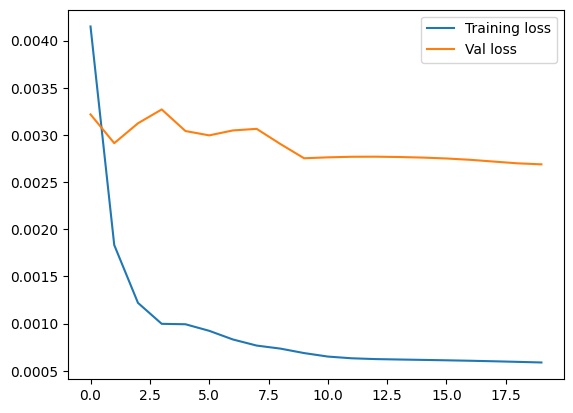

In [29]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [30]:
pred_dataset = X_test

model.eval()
with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

In [31]:
preds = np.array(preds)
preds = preds.reshape(-1, 1)

In [32]:
actual = scaler.inverse_transform(y_test)
predicted = scaler.inverse_transform(preds)

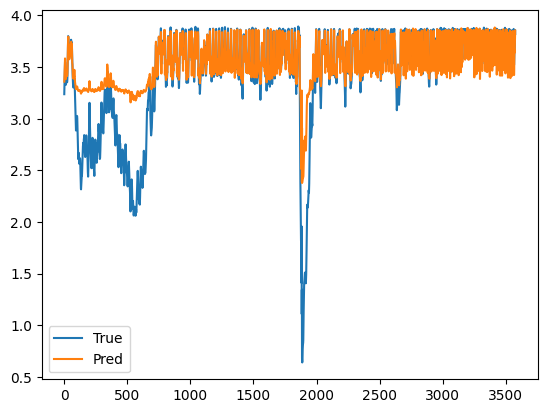

In [33]:
plt.plot(actual, label = 'True')
plt.plot(predicted, label = 'Pred')
plt.legend()
plt.show()

In [34]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'CNN-LSTM RMSE: {rmse:.4f}')

CNN-LSTM RMSE: 0.1044
